In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use({'figure.facecolor':'white'})

Считываем данные

In [3]:
data = pd.read_excel('../data4.xlsx')

s1 (мм) - расстояние, пройденное каплей вниз,

s2 (мм) - расстояние, пройденное каплей вверх,


t1 (c) -  время прохождения капли вниз,

t2 (c) -  время прохождения капли вверх,

In [4]:
data.shape

(60, 5)

In [6]:
data.dropna(inplace=True)
data = data[data.t1 < data.t2]
data.head()

,s1,t1,s2,t2,number
0,0.29,1.22,0.29,3.35,1
1,0.29,1.43,0.29,3.35,1
2,0.29,1.42,0.29,3.43,1
3,0.29,1.33,0.29,3.38,1
4,0.29,1.26,0.29,3.44,1


Строим гистаграму количества измерений каплей, по которой выбираем первые пять каплей с наибольшими
количеством измерений для их дальнейшего анализа

<AxesSubplot:xlabel='number', ylabel='count'>

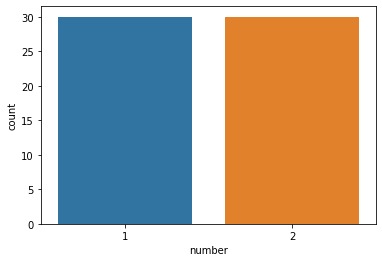

In [7]:
count_of_drops = data.groupby('number', as_index=False) \
    .agg({'s1': 'count'}) \
    .rename(columns={'s1': 'count'}) \
    .sort_values(by=['count'], ascending=False)
sns.barplot(data=count_of_drops, x='number', y='count', order=count_of_drops.number)

In [6]:
data_filt = data.merge(count_of_drops[:5], on='number', how='right')
data_filt.head()

,s1,t1,s2,t2,number,count
0,0.29,0.93,0.29,1.07,13,47
1,0.29,0.93,0.29,1.10,13,47
2,0.29,0.92,0.29,1.08,13,47
3,0.29,0.93,0.29,1.11,13,47
4,0.29,0.93,0.29,1.79,13,47


Функция, проводящая хи-квадрат тест для проверки распределения на нормальность.
Функция вохвращает расстояние хи-квадрат и p-значение.
Нулевая гипотеза утверждает, что измерения времени для каждой рассматриваемой
капли имеют нормальное распредление. Соответственно, если p-значение больше 0,05,
то принимается нулевая гипотеза о нормальности распределения.

In [7]:
from scipy.stats import chisquare, norm

def chi_test(data_t):
    mean = data_t.mean()
    std = data_t.std()
    count = data_t.count()
    data_norm = pd.Series((data_t.unique() - mean)/std)
    data_norm = data_norm.rename('zero_score').to_frame()
    data_norm['phi'] = norm.pdf(data_norm.zero_score)
    data_norm['Ni'] = np.ceil(count*data_norm.phi)
    data_norm['N'] = data_t.value_counts().to_numpy()

    chisq, p = chisquare(data_norm.N.to_numpy(), f_exp=data_norm.Ni.to_numpy())
    return chisq, p

Рассчитываем для каждой из пяти капель расстояние хи-квадрат и p-значение для величин t1 и t2

In [8]:
numbers = data_filt.number.unique()
for num in numbers:
    chisq_t1, p_t1 = chi_test(data_filt[data_filt.number==num].t1)
    chisq_t2, p_t2 = chi_test(data_filt[data_filt.number==num].t2)
    print(f'Для {num}-ой капли:\n\t'
          f't1: хи-квадрат: {round(chisq_t1,3)}, p: {round(p_t1,4)}\n\t'
          f't2: хи-квадрат: {round(chisq_t2, 3)}, p: {round(p_t2, 4)}\n')

Для 13-ой капли:
	t1: хи-квадрат: 29.587, p: 0.0
	t2: хи-квадрат: 57.472, p: 0.0

Для 15-ой капли:
	t1: хи-квадрат: 0.817, p: 0.9362
	t2: хи-квадрат: 42.41, p: 0.0

Для 16-ой капли:
	t1: хи-квадрат: 7.2, p: 0.1257
	t2: хи-квадрат: 14.167, p: 0.1165

Для 10-ой капли:
	t1: хи-квадрат: 4.25, p: 0.2357
	t2: хи-квадрат: 21.5, p: 0.0003

Для 3-ой капли:
	t1: хи-квадрат: 4.833, p: 0.4366
	t2: хи-квадрат: 3.667, p: 0.453



Для каплей под номерами 16 и 3  нулевая гипотеза о нормальности распределения значений времени прохождения капель
принимается. Для каплей 10(вверх), 13 и 15(вверх) - нет. Причина может заключаться в том, что в выборке присутствуют значения времени,
соответствующие ускоренному движению капель, либо некорректно снятые измерения.

Для данных капель примем значения, попадающие в интервал *[Q1 - (Q3-Q1), Q3 + (Q3-Q1)]*,

где *Q3* - 75% перцентиль выборки,
    *Q1* - 25% перцентиль выборки.

То есть отфильтровываться будут значения, имеющие малую частоту и слишком большие и маленькие значения относительно
медианы выборки.

Text(0.5, 1.0, '13-ая капля движение вверх')

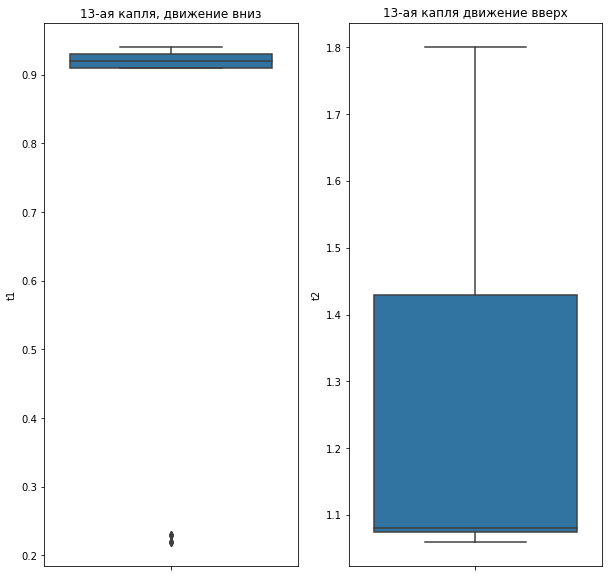

In [9]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
ax1 = sns.boxplot(data=data_filt[data_filt.number == 13], y='t1', ax=ax1)
ax1.set_title(f'13-ая капля, движение вниз')
ax2 = sns.boxplot(data=data_filt[data_filt.number == 13], y='t2', ax=ax2)
ax2.set_title(f'13-ая капля движение вверх')

In [10]:
data_filt_v2 = data_filt.copy()
data_filt_v2['Q1_t1'] = data_filt_v2.number.map(lambda num: data_filt[data_filt.number==num].t1.quantile(0.25))
data_filt_v2['Q3_t1'] = data_filt_v2.number.map(lambda num: data_filt[data_filt.number==num].t1.quantile(0.75))
data_filt_v2['Q1_t2'] = data_filt_v2.number.map(lambda num: data_filt[data_filt.number==num].t2.quantile(0.25))
data_filt_v2['Q3_t2'] = data_filt_v2.number.map(lambda num: data_filt[data_filt.number==num].t2.quantile(0.75))
data_filt_v2['IRQ_t1'] = data_filt_v2['Q3_t1'] - data_filt_v2['Q1_t1']
data_filt_v2['IRQ_t2'] = data_filt_v2['Q3_t2'] - data_filt_v2['Q1_t2']

data_filt_v2 = data_filt_v2[(data_filt_v2.t1 <= data_filt_v2.Q3_t1 + 1.5 * data_filt_v2.IRQ_t1)&
                            (data_filt_v2.t1 >= data_filt_v2.Q1_t1 - 1.5 * data_filt_v2.IRQ_t1)&
                            (data_filt_v2.t2 <= data_filt_v2.Q3_t2 + 1.5 * data_filt_v2.IRQ_t2)&
                            (data_filt_v2.t2 >= data_filt_v2.Q1_t2 - 1.5 * data_filt_v2.IRQ_t2) |
                            (data_filt_v2.number.isin([16, 3]))]
numbers = data_filt_v2.number.unique()
for num in numbers:
    chisq_t1, p_t1 = chi_test(data_filt_v2[data_filt_v2.number==num].t1)
    chisq_t2, p_t2 = chi_test(data_filt_v2[data_filt_v2.number==num].t2)
    print(f'Для {num}-ой капли:\n\t'
          f't1: хи-квадрат: {round(chisq_t1,3)}, p: {round(p_t1,4)}\n\t'
          f't2: хи-квадрат: {round(chisq_t2, 3)}, p: {round(p_t2, 4)}\n')

Для 13-ой капли:
	t1: хи-квадрат: 7.841, p: 0.0494
	t2: хи-квадрат: 41.368, p: 0.0

Для 15-ой капли:
	t1: хи-квадрат: 0.283, p: 0.9631
	t2: хи-квадрат: 40.712, p: 0.0

Для 16-ой капли:
	t1: хи-квадрат: 7.2, p: 0.1257
	t2: хи-квадрат: 14.167, p: 0.1165

Для 10-ой капли:
	t1: хи-квадрат: 2.0, p: 0.1573
	t2: хи-квадрат: 1.667, p: 0.4346

Для 3-ой капли:
	t1: хи-квадрат: 4.833, p: 0.4366
	t2: хи-квадрат: 3.667, p: 0.453



Построим гистограммы распределений времени движения для каждой капли, предварительно вычислив значения времени
по z-шкале

D:\Anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\myenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

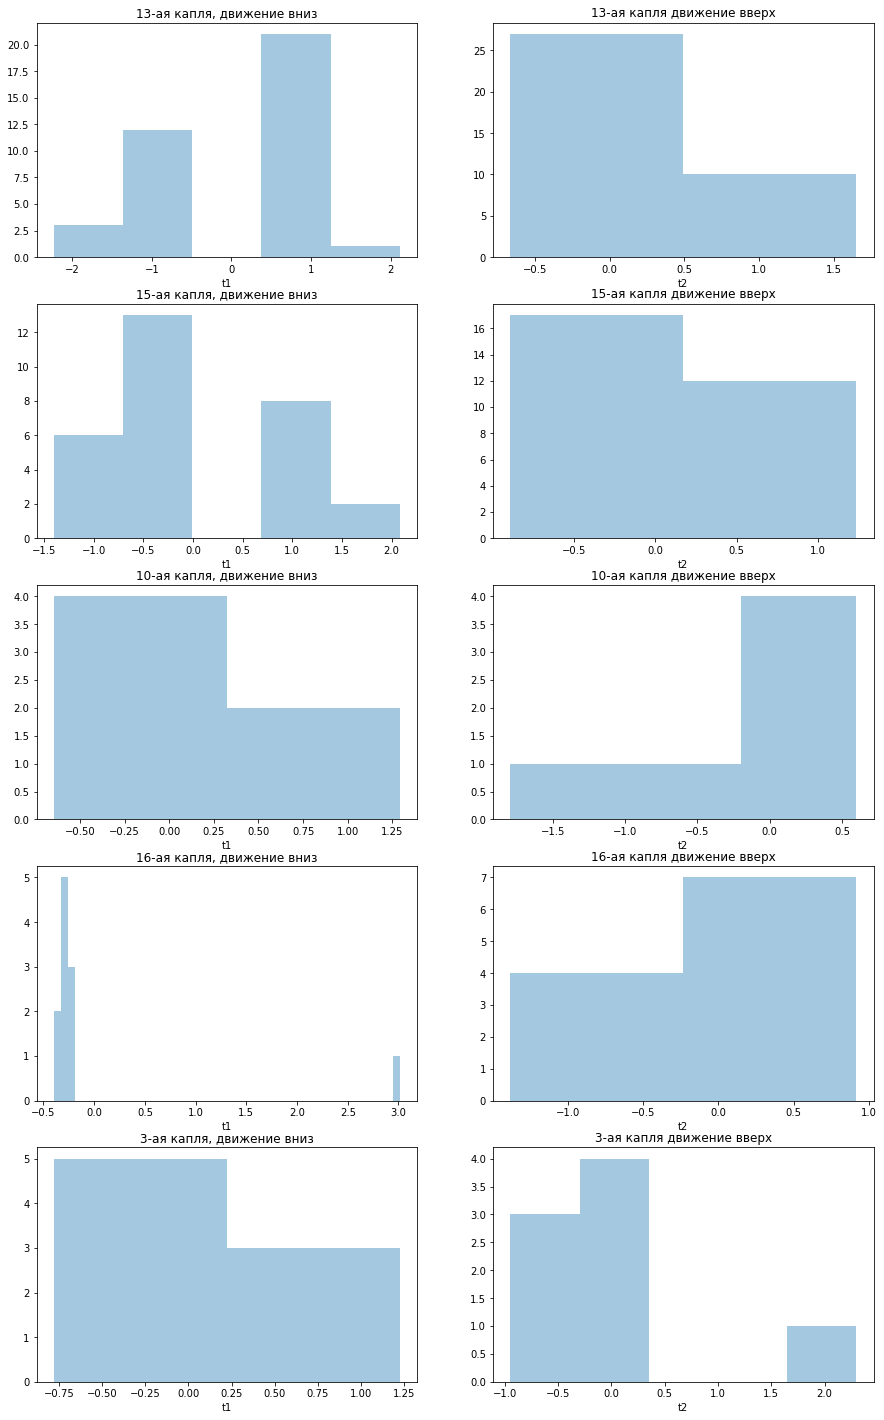

In [11]:
def to_zscore(pd_series):
    return (pd_series - pd_series.mean())/pd_series.std()

_, ax = plt.subplots(ncols=2, nrows=5, figsize=(15, 25))
for i, num in enumerate([13, 15, 10, 16, 3]):
    ax[i, 0] = sns.distplot(to_zscore(data_filt_v2[data_filt_v2.number == num].t1), ax=ax[i, 0], kde=False)
    ax[i, 0].set_title(f'{num}-ая капля, движение вниз')
    ax[i, 1] = sns.distplot(to_zscore(data_filt_v2[data_filt_v2.number == num].t2), ax=ax[i, 1], kde=False)
    ax[i, 1].set_title(f'{num}-ая капля движение вверх')

Рассчитаем скорость движения капель:

In [12]:
data_filt_v2['v1'] = data_filt_v2['s1']/data_filt_v2['t1']*1e-3
data_filt_v2['v2'] = data_filt_v2['s2']/data_filt_v2['t2']*1e-3

Рассчитаем значения заряда и радиуса капель:

In [13]:
C1 = 2.73e-11
C2 = 6.37e-5
U = 300
data_filt_v2['Q'] = C1*((data_filt_v2['v1']+data_filt_v2['v2'])*
                        np.sqrt(data_filt_v2['v1']-data_filt_v2['v2']))/U

Построим график зависимости значения заряда капли от её радиуса для всех капель:

In [14]:
data_filt_v2['r'] = C2*np.sqrt(data_filt_v2['v1'] - data_filt_v2['v2'])

<AxesSubplot:xlabel='r', ylabel='Q'>

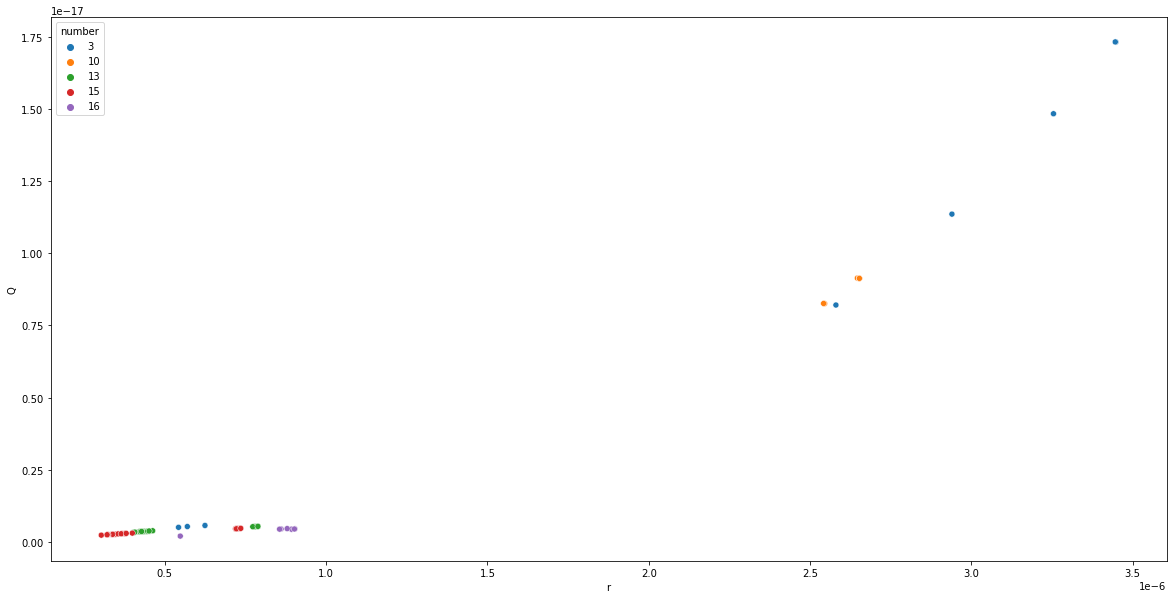

In [15]:
_, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(x='r', y='Q', hue='number',data=data_filt_v2, ax=ax, palette='tab10') #, legend='full'

<AxesSubplot:xlabel='r', ylabel='Q'>

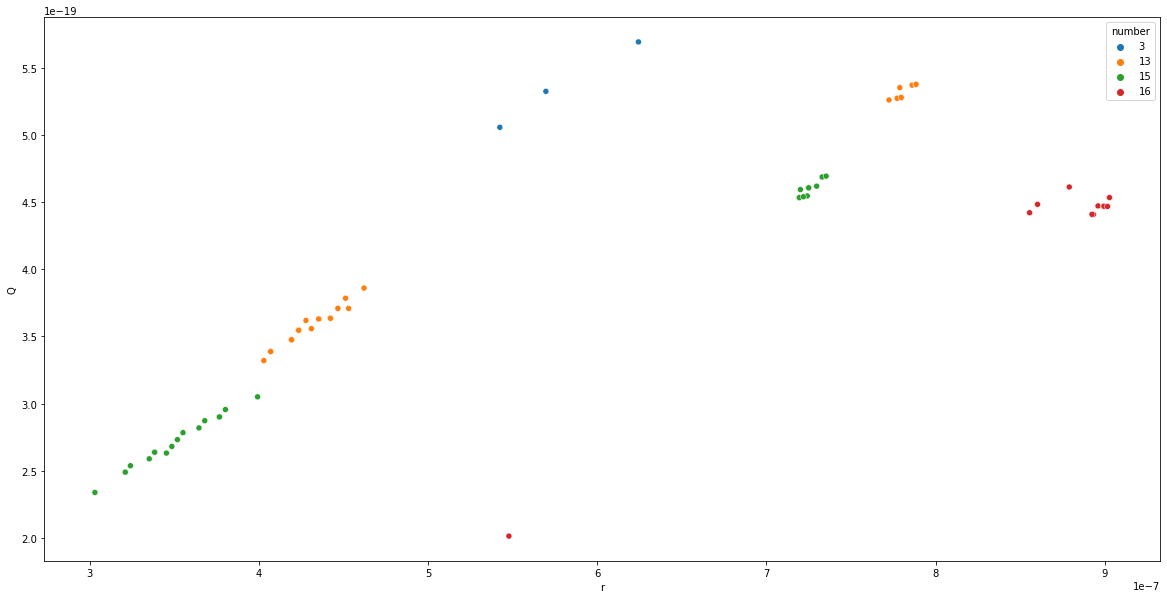

In [16]:
data_filt_v3 = data_filt_v2[(data_filt_v2.Q<0.10e-17)].copy()
_, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(x='r', y='Q', hue='number',data=data_filt_v3, ax=ax, palette='tab10')